<a href="https://www.kaggle.com/code/vaibsdev/notebook5d95578c5e?scriptVersionId=229006732" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import pickle
import warnings
import pandas as pd
!pip install torchinfo
from torchinfo import summary

warnings.filterwarnings('ignore')

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")


def move_to_device(obj, device):
    if isinstance(obj, torch.nn.Module):
        return obj.to(device)
    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    return obj


sample_tensor = torch.tensor([1.0]).to(device)
print(f"Tensor on {sample_tensor.device}")


Using device: cuda
CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: Tesla P100-PCIE-16GB
Tensor on cuda:0


In [3]:

class EarlyStopping:
    """Early stopping handler to prevent overfitting"""
    def __init__(self, patience=5, min_delta=0.001, save_path="best_model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.save_path = save_path
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            # Save the best model
            torch.save(model.state_dict(), self.save_path)
            print(f"[INFO] Model checkpoint saved to {self.save_path}")
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("[INFO] Early stopping triggered.")
                return True
        return False

In [4]:

csv_path = '/kaggle/input/mst-e-data-1/mst-e_data/mst-e_image_details.csv'
image_data = pd.read_csv(csv_path)


image_paths = []
labels = []


base_image_dir = "/kaggle/input/mst-e-data-1/mst-e_data"


unique_mst_classes = sorted(image_data['MST'].unique())
class_to_idx = {class_name: idx for idx, class_name in enumerate(unique_mst_classes)}
num_classes = len(unique_mst_classes)
print(f"Number of unique MST classes: {num_classes}")
print(f"Class mapping: {class_to_idx}")


for index, row in image_data.iterrows():
    # Get image details from your columns
    image_id = row['image_ID']
    subject_name = row['subject_name']

 
    mst_class = row['MST']
    class_idx = class_to_idx[mst_class]

    image_path = os.path.join(base_image_dir, subject_name, f"{image_id}")

    # Skip if this is an MP4 file
    if image_path.lower().endswith('.mp4'):
        continue

    
    if os.path.exists(image_path):
        image_paths.append(image_path)
        labels.append(class_idx)  
    else:
        print(f"Image not found: {image_path}")

print(f"Found {len(image_paths)} images across {num_classes} MST classes")

Number of unique MST classes: 10
Class mapping: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}
Image not found: /kaggle/input/mst-e-data-1/mst-e_data/subject_18/PXL_20220922_183142438.jpg 
Image not found: /kaggle/input/mst-e-data-1/mst-e_data/subject_2/bottom
Found 1510 images across 10 MST classes


In [5]:
class SkinToneDataset(Dataset):
    """Custom Dataset for loading skin tone images"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

In [6]:
class SkinToneModel(nn.Module):
    """Convolutional Neural Network for skin tone classification"""
    def __init__(self, num_classes, dropout_rate=0.5):
        super(SkinToneModel, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        #  Block 5
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.global_avg_pool(x)
        x = self.fc_block(x)
        return x


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = SkinToneDataset(image_paths, labels, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4,persistent_workers=True,pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4,persistent_workers=True,pin_memory = True)

device = torch.device("cuda" if torch.cuda.is_available() else print("ERROR"))
model = SkinToneModel(num_classes=num_classes).to(device)


print(summary(model, input_size=(1, 3, 224, 224)))


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Layer (type:depth-idx)                   Output Shape              Param #
SkinToneModel                            [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-6                  [1, 128, 112, 112]        256
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-8                    [1, 128, 56, 56]          --
├─Sequential: 1-3                        [1, 256, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          295,168
│

In [7]:

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)  # Move to GPU

        optimizer.zero_grad()  

        outputs = model(inputs)  
        loss = criterion(outputs, labels)

        loss.backward()  
        optimizer.step() 

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100.0 * correct / total
    print(epoch_loss)
    print(epoch_acc)

    return epoch_loss, epoch_acc


# Ensure model is on GPU
model.to(device)


early_stopping = EarlyStopping(patience=5, min_delta=0.001, save_path="best_skin_tone_model.pth")

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

     # Save loss and accuracy for visualization
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    if early_stopping(val_loss, model):
        print(f"Training stopped early at epoch {epoch+1}")
        break

print(f'Training complete! Best validation loss: {early_stopping.best_loss:.4f}')

# Load the best model for evaluation
model.load_state_dict(torch.load(early_stopping.save_path, map_location=device))  
final_val_loss, final_val_acc = validate(model, val_loader, criterion, device)
print(f'Final model performance - Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_acc:.2f}%')


1.8969054198422968
28.807947019867548
Epoch 1/30: Train Loss: 1.7974, Train Acc: 32.78%, Val Loss: 1.8969, Val Acc: 28.81%
[INFO] Model checkpoint saved to best_skin_tone_model.pth
3.0538760336819073
27.483443708609272
Epoch 2/30: Train Loss: 1.2646, Train Acc: 52.73%, Val Loss: 3.0539, Val Acc: 27.48%
1.0461269119717427
65.23178807947019
Epoch 3/30: Train Loss: 0.9225, Train Acc: 67.38%, Val Loss: 1.0461, Val Acc: 65.23%
[INFO] Model checkpoint saved to best_skin_tone_model.pth
1.817000902251692
53.311258278145694
Epoch 4/30: Train Loss: 0.7711, Train Acc: 72.02%, Val Loss: 1.8170, Val Acc: 53.31%
0.40768420854151644
87.41721854304636
Epoch 5/30: Train Loss: 0.6308, Train Acc: 77.98%, Val Loss: 0.4077, Val Acc: 87.42%
[INFO] Model checkpoint saved to best_skin_tone_model.pth
0.4932300203683361
84.76821192052981
Epoch 6/30: Train Loss: 0.5233, Train Acc: 82.78%, Val Loss: 0.4932, Val Acc: 84.77%
0.5659797669246497
81.78807947019868
Epoch 7/30: Train Loss: 0.3748, Train Acc: 87.75%, Val

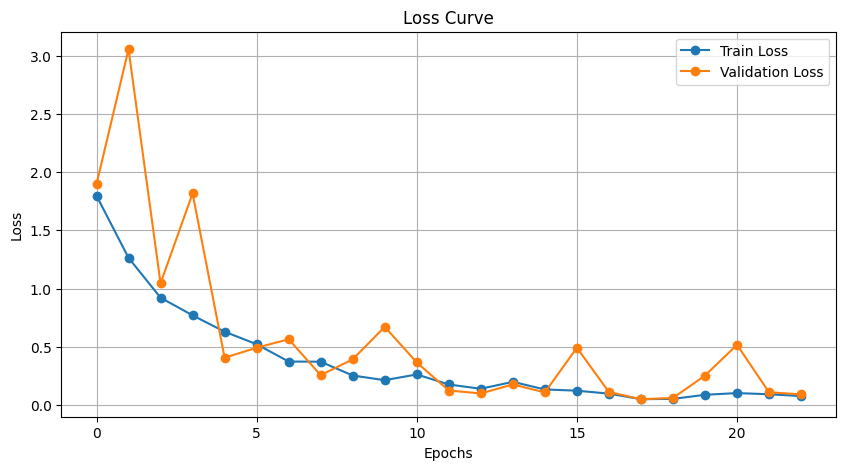

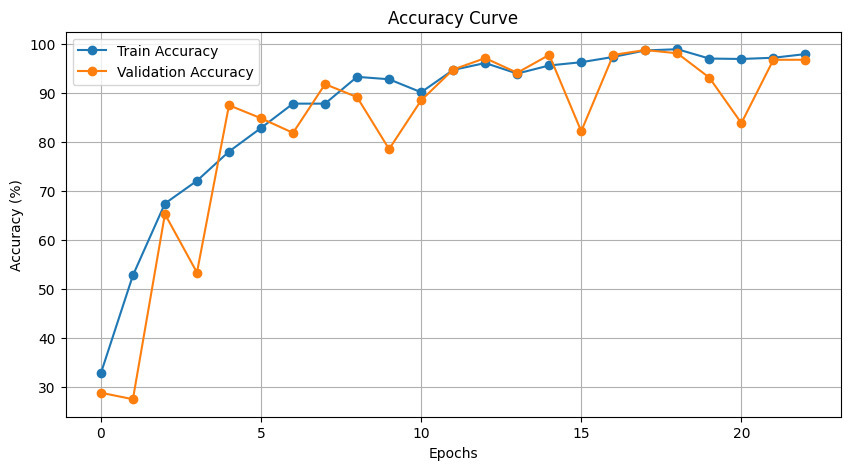

In [8]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy", marker="o")
plt.plot(val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.grid()
plt.show()